# Section B

In [52]:
import torch as tt
import torch.nn as nn
import torch.optim as oo

## [1] Loading data

In [53]:
# Load Data from car train and car test
# here we shall use Dataloader and Dataset from pytorch

from torch.utils.data import Dataset, DataLoader
import numpy as np 

# to define a custom Dataset, we have to inherit from pytorch Dataset class 
#   and define 3 main methods - __init__, __len__ and __getitem__

class CarDataset(Dataset):

    def __init__(self, csv): 
        # initialize a car-dataset by reading from a csv file
        data = tt.tensor(np.loadtxt(
            csv,                # dataset csv-file
            delimiter=",",      # (C)omma (S)eperated (V)alues
            skiprows=1,         # skip the header [carlength,carwidth,carheight,horsepower,peakrpm,price]
            dtype=np.float32,   
        )) 
        # this will produce an array of size (n x 6) where
        #  each row (in n) is a sample, 
        #  each col is a feature, last col is target feature

        # normalize this dataset, since features have wide range of values
        dm, dv = tt.mean(data, dim=0), tt.var(data, dim=0)
        self.data = (data-dm)/(dv**0.5)

        self.X = self.data[:, 0:5] # first 5 five cols are input X 
        self.Y = self.data[:, 5: ]  # last col is label Y 

        self.L = len(self.data)

    def __len__(self): return self.L # total samples in this dataset
    
    def __getitem__(self, index): 
        # should return a single sample as X,Y
        return self.X[index, :], self.Y[index, :]


In [54]:
# initialize training dataset
ds_train = CarDataset('car_train.csv')
ds_test = CarDataset('car_test.csv')

In [55]:
# check 
print('Trainset', ds_train.X.shape, ds_train.Y.shape, ds_train.L)
print('Testset', ds_test.X.shape, ds_test.Y.shape, ds_test.L)

Trainset torch.Size([80, 5]) torch.Size([80, 1]) 80
Testset torch.Size([20, 5]) torch.Size([20, 1]) 20


In [56]:
# we can read from dataset using indexing, this will call __getitem__ and return a (X, Y) pair
x,y = ds_test[2]
print(x, x.shape) 
print(y, y.shape)

tensor([ 0.9678,  1.5768, -1.2235,  1.8415, -0.8952]) torch.Size([5])
tensor([1.5375]) torch.Size([1])


In [57]:
# to actually read from dataset during training we shall use dataloader
# this allows us to define batch-size, shuffle, transforms etc on the dataset

# create a dataloader and specify batch size
dl = DataLoader(ds_test, batch_size=10, shuffle=False)

# enumerate through the dataloader
for i,(x,y) in enumerate(dl): print(f'batch #{i}\n{x.shape=}\n{x=} \n{y.shape=}\n{y=}\n\n')

# since there are 20 test points, this will create 4 batches of batch-size=5


batch #0
x.shape=torch.Size([10, 5])
x=tensor([[ 0.9163,  0.6758, -1.6392,  0.8525,  1.8175],
        [ 0.9163,  0.6758, -1.6392, -0.1023, -0.8952],
        [ 0.9678,  1.5768, -1.2235,  1.8415, -0.8952],
        [ 0.9678,  1.5768, -1.2235,  1.8415, -0.8952],
        [ 0.9678,  1.5768, -1.2235,  1.8415, -0.8952],
        [ 0.7619,  0.6758, -0.4962, -0.1023, -0.8952],
        [ 0.7619,  0.6758, -0.4962, -0.1023, -0.8952],
        [ 0.7619,  0.6758, -0.4962,  0.8525,  1.8175],
        [ 0.7619,  0.6758, -0.4962,  0.8525,  1.8175],
        [-1.0656, -0.9260,  1.0105, -0.7502,  0.1899]]) 
y.shape=torch.Size([10, 1])
y=tensor([[ 0.4734],
        [-0.1084],
        [ 1.5375],
        [ 2.4302],
        [ 2.2788],
        [-0.7102],
        [-0.2319],
        [ 0.2025],
        [ 0.2025],
        [-1.3040]])


batch #1
x.shape=torch.Size([10, 5])
x=tensor([[-1.0656, -0.9260,  1.0105, -1.2277, -1.9803],
        [-1.0656, -0.9260,  1.0105, -0.7502,  0.1899],
        [-1.0656, -0.9260,  1.0105, -

# [1] Linear Regression

### making the model

In [58]:
# the linear regression model is of the form:
# y = w1*x1 + w2*x2 + ... + wn*xn + b
# which can be expressed as a dot product of the weight-vector (w) and the input vector (x) plus the bias (b)
# i.e., y = W*X + b
# since there are 5 input features (x) - carlength, carwidth, carheight, horsepower, peakrpm
# we have n=5
# we have to predict a single feature (y) - price
# our linear model would be as follows:

class LinearModel(nn.Module):
    # Note: we dont use any activation here
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(tt.rand(size=(5,1)))   
        self.b = nn.Parameter(tt.rand(size=(1,1)))       

    def forward(self, X): #<--- input X is supposed to be a 5-dimensional vector
        return X@self.W + self.b 
    
    

In [59]:
model = LinearModel()
print(model.state_dict())

OrderedDict({'W': tensor([[0.6770],
        [0.1900],
        [0.8995],
        [0.2416],
        [0.5263]]), 'b': tensor([[0.5005]])})


In [60]:
# for regression we use MSELoss
lossfn = nn.MSELoss()

# Stohcastic Gradient Descent (SGD)
optim = oo.SGD( 
    model.parameters(), #<--- pass the parameters of the model to be trained
    lr=0.01            #<--- set the learning rate
    )

epoch 20 of 1000: training_loss=0.14643707405775785, val_loss=0.32157227396965027
epoch 40 of 1000: training_loss=0.12980124168097973, val_loss=0.2728136479854584
epoch 60 of 1000: training_loss=0.12774764513596892, val_loss=0.25572669506073
epoch 80 of 1000: training_loss=0.12692164815962315, val_loss=0.24568824470043182
epoch 100 of 1000: training_loss=0.1262833084911108, val_loss=0.2387409210205078
epoch 120 of 1000: training_loss=0.12567025143653154, val_loss=0.23358972370624542
epoch 140 of 1000: training_loss=0.12586447596549988, val_loss=0.22967907786369324
epoch 160 of 1000: training_loss=0.12533847196027637, val_loss=0.22751298546791077
epoch 180 of 1000: training_loss=0.12564605427905917, val_loss=0.2251049280166626
epoch 200 of 1000: training_loss=0.12599052325822413, val_loss=0.22413650155067444
epoch 220 of 1000: training_loss=0.12535540480166674, val_loss=0.22306063771247864
epoch 240 of 1000: training_loss=0.12569979391992092, val_loss=0.22200675308704376
epoch 260 of 10

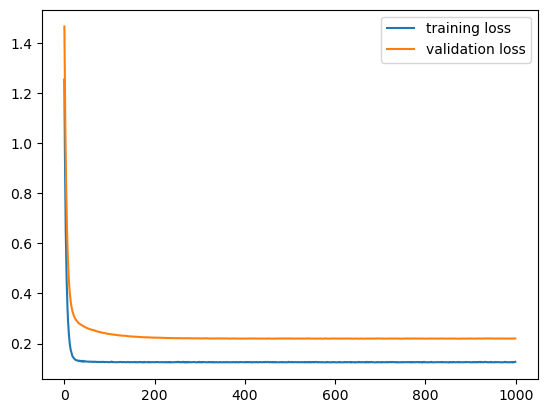


Training Loss = 0.12700209952890873
Validation Loss = 0.2202470749616623



In [61]:
loss_history=[] # will plot it later to see it decreasing ... 
val_loss_history=[]
# ready dataloader
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=len(ds_test), shuffle=False) # we will test the whole test dataset, so batch size is same as len

# Training loop
max_epoch = 1000
for epoch in range(max_epoch):  # Number of epochs
    # in each epoch train the whole dataset but divide by batch
    batch_loss_history = []
    #print(f'Starting epoch {epoch+1} of {max_epoch}')
    for batch,(x,y) in enumerate(dl_train):
        optim.zero_grad()# Clear gradients (can be done after optimizer.step too)
        p = model(x)        # Forward pass
        loss = lossfn(p, y)  # Compute loss
        loss.backward()     # Backward pass
        optim.step()        # Update weights

        batch_loss_history.append(loss.item())
        #print(f'\t{batch=}, loss={batch_loss_history[-1]}')

    loss_history.append(sum(batch_loss_history)/len(batch_loss_history)) #<--- record only average batch loss

    # testing
    with tt.no_grad():
        for batch,(x,y) in enumerate(dl_test): # will be only one batch
            p = model(x)        # Forward pass
            loss = lossfn(p, y)  # Compute loss
            val_loss_history.append(loss.item())

    if (epoch+1) % 20 == 0:
        print(f'epoch {epoch+1} of {max_epoch}: training_loss={loss_history[-1]}, val_loss={val_loss_history[-1]}')

# finally plot the loss
import matplotlib.pyplot as plt
plt.plot(loss_history, label='training loss',)
plt.plot(val_loss_history, label='validation loss', )
plt.legend()
plt.show()

print(f"""
Training Loss = {loss_history[-1]}
Validation Loss = {val_loss_history[-1]}
""")

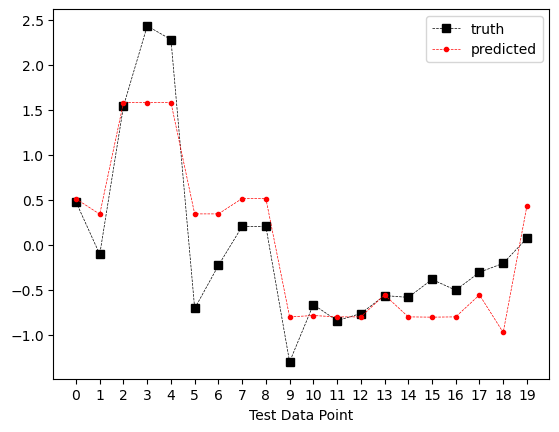

In [62]:
# plot predictions and truth for test set 
with tt.no_grad():
    for batch,(x,y) in enumerate(dl_test): # will be only one batch
        p = model(x)        # Forward pass
    
    plt.plot(y, label='truth', marker='s', linestyle='dashed', color='black', linewidth=0.5)
    plt.plot(p, label='predicted', marker='.', linestyle='dashed', color='red', linewidth=0.5)
    plt.xticks(range(len(y)))
    plt.xlabel("Test Data Point") # there are 20 points in test dataset
    plt.legend()

In [63]:
print('Final Model Weights')
print(model.state_dict())

Final Model Weights
OrderedDict({'W': tensor([[ 0.2064],
        [ 0.2108],
        [ 0.0309],
        [ 0.5286],
        [-0.1232]]), 'b': tensor([[0.0006]])})


# [2] Logistic Regression

## Loading Dataset

In [64]:
from torch.utils.data import Dataset, DataLoader,random_split
import numpy as np

class BreastDataset(Dataset):
    
    def __init__(self, csv):
        # Load raw data as strings first (to handle 'M'/'B')
        raw_data = np.loadtxt(csv, delimiter=",", skiprows=1, dtype=str)
        
        # Extract target column (index 1) and map M->1, B->0
        target_str = raw_data[:, 1]
        target_num = np.where(target_str == 'M', 1.0, 0.0).astype(np.float32)
        
        # Remove target column from features
        features_str = np.delete(raw_data, 1, axis=1).astype(np.float32)
        
        # Convert to tensors
        X = tt.tensor(features_str, dtype=tt.float32)
        Y = tt.tensor(target_num, dtype=tt.float32).unsqueeze(1)  # shape [N,1]
        
        # Normalize features only
        dm, dv = tt.mean(X, dim=0), tt.var(X, dim=0)
        X = (X - dm) / (dv ** 0.5)
        
        self.X = X
        self.Y = Y
        self.L = len(X)
        
    def __len__(self):
        return self.L
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [65]:
ds = BreastDataset('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data')
# import pandas as pd
# df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data")
# df.head()

**Train Test split**

In [66]:
# Define split sizes
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size

# Split the dataset
ds_train, ds_test = random_split(ds, [train_size, test_size])

# Create DataLoaders
dl_train = DataLoader(ds_train, batch_size=30, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=len(ds_test), shuffle=False)

print(ds[0])


(tensor([-0.2364,  1.8305, -0.3580,  1.6876,  1.9087, -0.8245, -0.4851, -0.0193,
         0.5548,  0.0053, -0.8671,  0.5055, -0.8759,  0.2698,  0.7496, -0.6047,
        -0.6904, -0.4389,  0.2610, -0.8029, -0.0977,  1.8118, -0.3715,  1.5437,
         1.8974, -0.3732, -0.4277, -0.1433,  1.0943, -0.2402,  0.2850]), tensor([1.]))


*reading sample data*

In [67]:
x,y = ds_test[2]
print(x, x.shape)
print(y, y.shape)

tensor([-0.2362, -0.6217,  0.5188, -0.6335, -0.6129,  0.0967, -0.4879, -0.6955,
        -0.7423, -0.4486, -0.1179, -0.3339, -0.5339, -0.4260, -0.3389,  0.2532,
        -0.0205, -0.4472, -0.6606, -0.9373,  0.0247, -0.5357,  0.0746, -0.5851,
        -0.5205,  0.7750, -0.0871, -0.5823, -0.6394, -0.7475,  0.0847]) torch.Size([31])
tensor([0.]) torch.Size([1])


### Making the Model

In [68]:
# the logistic regression model will basically take 
# y = w1*x1 + w2*x2 + ...... + b as input and returns the sigmoid of this as output 
# then we use 0.5 > as 0 and 0.5 < as 1

# we use sigmoid as activation here


class LogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(tt.rand(size=(31, 1)))
        self.b = nn.Parameter(tt.rand(size=(1,1)))
    
    def forward(self, X):
        return tt.sigmoid(X@self.W + self.b)


In [69]:
logistic_model = LogisticRegression()
print(model.state_dict()) # prints the learnable parameters

OrderedDict({'W': tensor([[ 0.2064],
        [ 0.2108],
        [ 0.0309],
        [ 0.5286],
        [-0.1232]]), 'b': tensor([[0.0006]])})


In [70]:
# for binary classification we use binary cross-entropy loss function
loss_fn = nn.BCELoss()

# Stohcastic Gradient Descent (SGD)
optimizer = oo.SGD(
    logistic_model.parameters(),
    lr = 0.01
)

epoch 20/1000: train_loss=0.2832, val_loss=0.2107, val_acc=0.9123
epoch 40/1000: train_loss=0.1289, val_loss=0.1308, val_acc=0.9474
epoch 60/1000: train_loss=0.0925, val_loss=0.1079, val_acc=0.9561
epoch 80/1000: train_loss=0.0839, val_loss=0.1004, val_acc=0.9561
epoch 100/1000: train_loss=0.0799, val_loss=0.0969, val_acc=0.9561
epoch 120/1000: train_loss=0.0800, val_loss=0.0941, val_acc=0.9649
epoch 140/1000: train_loss=0.0792, val_loss=0.0923, val_acc=0.9649
epoch 160/1000: train_loss=0.0714, val_loss=0.0902, val_acc=0.9649
epoch 180/1000: train_loss=0.0672, val_loss=0.0886, val_acc=0.9649
epoch 200/1000: train_loss=0.0697, val_loss=0.0873, val_acc=0.9561
epoch 220/1000: train_loss=0.0639, val_loss=0.0861, val_acc=0.9561
epoch 240/1000: train_loss=0.0640, val_loss=0.0852, val_acc=0.9561
epoch 260/1000: train_loss=0.0615, val_loss=0.0844, val_acc=0.9561
epoch 280/1000: train_loss=0.0607, val_loss=0.0837, val_acc=0.9649
epoch 300/1000: train_loss=0.0657, val_loss=0.0828, val_acc=0.9649

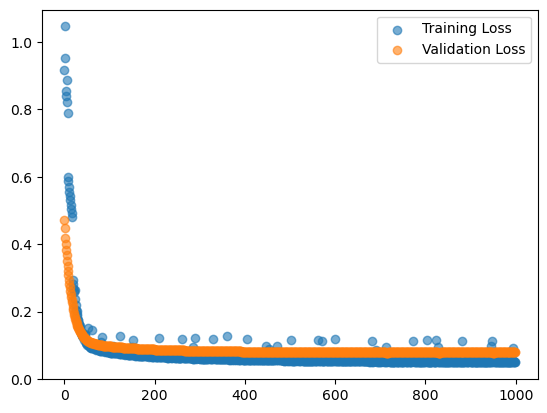

In [71]:
logistic_loss_history=[]
logistic_val_loss_history=[]

# Training loop
max_epoch = 1000
for epoch in range(max_epoch):
    logistic_batch_loss_history = []
    
    for batch, (x,y) in enumerate(dl_train):
        optimizer.zero_grad()
        # print(x.shape)# clears the previous gradient accumulated by autograd
        y_pred = logistic_model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        logistic_batch_loss_history.append(loss.item())
    
    logistic_loss_history.append(sum(logistic_batch_loss_history)/len(logistic_batch_loss_history))
    
    
    # testing
    with tt.no_grad():
        for batch, (x,y) in enumerate(dl_test):
            y_pred = logistic_model(x)
            loss = loss_fn(y_pred, y)
            logistic_val_loss_history.append(loss.item())
          
    # Accuracy Calc
    with tt.no_grad():
        correct = 0
        total = 0
        for x, y in dl_test:
            preds = (logistic_model(x) > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
        acc = correct / total
        
      
    if (epoch + 1) % 20 == 0:
        print(f"epoch {epoch+1}/{max_epoch}: "
              f"train_loss={logistic_loss_history[-1]:.4f}, "
              f"val_loss={logistic_val_loss_history[-1]:.4f}, "
              f"val_acc={acc:.4f}")   
        
        



plt.scatter(range(len(logistic_loss_history)), logistic_loss_history, label='Training Loss', alpha=0.6)
plt.scatter(range(len(logistic_val_loss_history)), logistic_val_loss_history, label='Validation Loss', alpha=0.6)
plt.legend()
plt.show()


        
        

## Confusion Matrix and Accuracy, Precision and Recall

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import numpy as np

y_true_list = []
y_pred_list = []

# Puting model in evaluation mode & disableing gradient tracking
logistic_model.eval()
with tt.no_grad():
    for x, y in dl_test:
        probs = logistic_model(x)
        preds = (probs > 0.5).float()  # Threshold at 0.5
        y_true_list.extend(y.cpu().numpy())
        y_pred_list.extend(preds.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)


#### Confusion Matrix

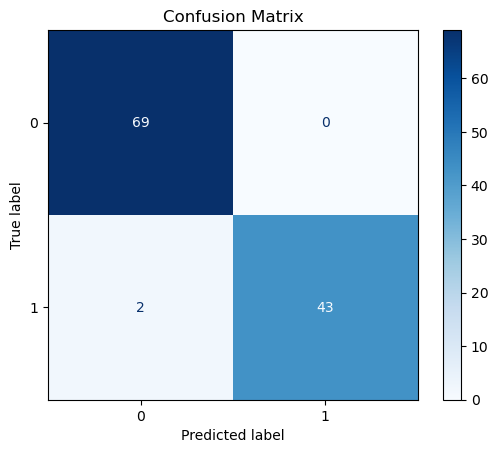

In [73]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



#### Accuray, Precision and recall

In [74]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

Accuracy:  0.9825
Precision: 1.0000
Recall:    0.9556
